In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
#Import Dataset
dataset = pd.read_csv('TrainData.csv.gz', compression ='gzip')
dataset.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,activity_count,user_session_count,date,weekday
0,2019-12-05 14:47:30+00:00,1,1005100,samsung,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,5,3
1,2020-01-26 03:11:20+00:00,1,1005266,xiaomi,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,26,6
2,2020-01-24 07:13:03+00:00,1,1201567,apple,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,24,4
3,2019-12-04 03:00:48+00:00,1,1701392,acer,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,4,2
4,2020-01-16 08:58:58+00:00,1,1005203,xiaomi,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,16,3


In [3]:
# Basic overview of all data points and categories. Further information is available in DataDescription.txt
dataset.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544820 entries, 0 to 3544819
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   event_time          3544820 non-null  object 
 1   event_type          3544820 non-null  int64  
 2   product_id          3544820 non-null  int64  
 3   brand               3544820 non-null  object 
 4   price               3544820 non-null  float64
 5   user_id             3544820 non-null  int64  
 6   user_session        3544785 non-null  object 
 7   activity_count      3544785 non-null  float64
 8   user_session_count  3544820 non-null  int64  
 9   date                3544820 non-null  int64  
 10  weekday             3544820 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 297.5+ MB


In [12]:
dataset.dropna(inplace = True)

#### Variable of interest: event_type
event_type is a binary categorical variable with the value of 1 and 2 (numeric) indicating whether items in cart remains in cart (event_type == 1) or is purchased eventually (event_type == 2)

##### Typical steps to follow while building a supervised machine learning model on a given dataset:
    o Partition the labeled dataset into two random portions – 75% to Train the model and 25% to Test the model.
    o Fit the desired supervised machine learning model on the Train set to predict response using the predictors.
    o Predict response using the predictors on the Test set using the machine learning model fit on the Train data.
    o Check the Prediction Accuracy of the model on both the Train and the Test sets using the “Confusion Matrix”

# Random Forest Model

In order to improve the accuracy of our classification, we use ensemble modelling methods. This means that we will divide the big data modelling tasks into smaller models and aggregate the predicted results based on this to decide the final predicted result. 

In order to achieve this, there are 2 key method of ensemble modelling methods: Boosting and Bagging.

We will first evaluate Bagging with the key model being a random forest classifier.

The idea behind a random forest is dividing the dataset into different smaller random samples selected with replacement to reduce the variance between variables. Moreover, we also randomly pick a few features (2) out of the set of 6 features used to predict the event_type. This is done to discount the effect of a dominant feature and introduce variants in the contributing trees, thus making the classification choice less biased towards certain features (predictors) based on train data.

Based on these 2 actions, multiple different classification trees are built and prediction is aggreagated result (each tree contribute 1 vote to the final classification).



In [13]:
#In order to create random forest model on randomized train and test set, we use Scikit-learn library
# Import essential models and functions from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [14]:
# Generate a one-hot encoding for brands as it is a nominal categorical variable
d = dataset.groupby('brand').size()
d.sort_values( ascending = False, inplace=True)
brand_code = {brand_name:x for x,brand_name in enumerate(d.index) }
dataset['brand'] = dataset['brand'].map(brand_code)
dataset.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,activity_count,user_session_count,date,weekday
0,2019-12-05 14:47:30+00:00,1,1005100,0,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,5,3
1,2020-01-26 03:11:20+00:00,1,1005266,2,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,26,6
2,2020-01-24 07:13:03+00:00,1,1201567,1,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,24,4
3,2019-12-04 03:00:48+00:00,1,1701392,10,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,4,2
4,2020-01-16 08:58:58+00:00,1,1005203,2,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,16,3


In [15]:
#split dataset in features and target variable
predictor_cols = ['price', 'brand', 'activity_count', 'user_session_count','weekday','date']
predictors = dataset[predictor_cols] # Features
response = dataset.event_type # Target variable

In [21]:
def RandomForest (response, predictors, depth): 
    #Step 1: Partition data into train and test dataset.
    X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size = 0.25) #default 75% train, 25% test split
              
    #Step 2:Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth = depth)     # create the random forest classifier object
    rf_classifier.fit(X_train, y_train)                          # train the random forest classifier
    
    #Step 3: Predict Response corresponding to Predictors
    y_train_pred = rf_classifier.predict(X_train)
    y_test_pred = rf_classifier.predict(X_test)


    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

    #Step 4: Check the Goodness of fit (GOF)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
    print()
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
    print()

    TN = confusion_matrix(y_test,y_test_pred)[0][0]
    FN = confusion_matrix(y_test,y_test_pred)[1][0]
    TP = confusion_matrix(y_test,y_test_pred)[1][1]
    FP = confusion_matrix(y_test,y_test_pred)[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print ("True Positive Rate: ", TPR)

    '''# Specificity or true negative rate
    TNR = TN/(TN+FP)
    print ("True Negative Rate: ", TNR)'''

    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print ("False Positive Rate: ", FPR)

    '''# False negative rate
    FNR = FN/(TP+FN)
    print ("False Negative Rate: ", FNR)'''


    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print ("Overall accuracy: ", ACC)
    print()
    print()

    return rf_classifier, ACC

In [18]:
dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3544785 entries, 0 to 3544819
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   event_time          3544785 non-null  object 
 1   event_type          3544785 non-null  int64  
 2   product_id          3544785 non-null  int64  
 3   brand               3544785 non-null  int64  
 4   price               3544785 non-null  float64
 5   user_id             3544785 non-null  int64  
 6   user_session        3544785 non-null  object 
 7   activity_count      3544785 non-null  float64
 8   user_session_count  3544785 non-null  int64  
 9   date                3544785 non-null  int64  
 10  weekday             3544785 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 324.5+ MB


Random forest of 100 trees of depth 2
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5914515524782328

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5917984375934471

True Positive Rate:  0.4609036283913131
False Positive Rate:  0.2973273779624878
Overall accuracy:  0.5917984375934471


Random forest of 100 trees of depth 4
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6025491727187514

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6018627912303923

True Positive Rate:  0.5985991777247102
False Positive Rate:  0.39537548410752343
Overall accuracy:  0.6018627912303923


Random forest of 100 trees of depth 6
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6118755519847378

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6113177995411856

True Positive Rate:  0.6421158707553725
False Positive Rate:  0.41470569253285755
Overall accuracy:  0.6113177995411856


Ra

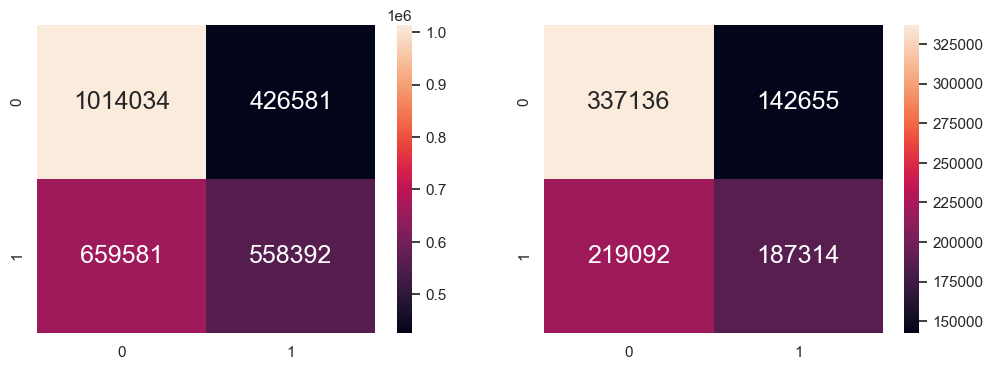

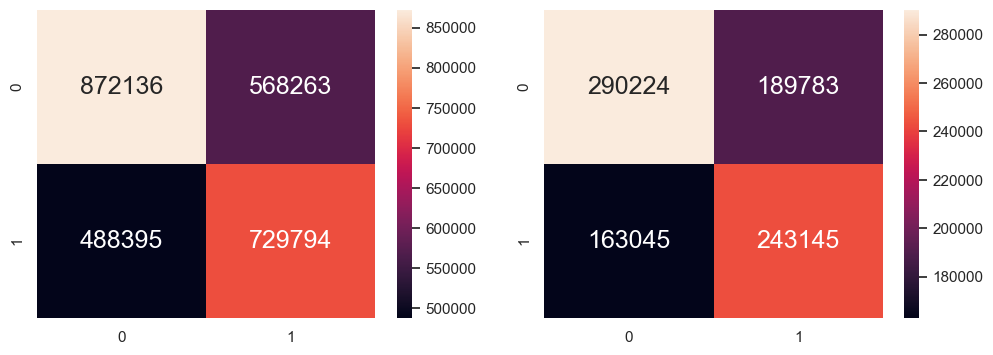

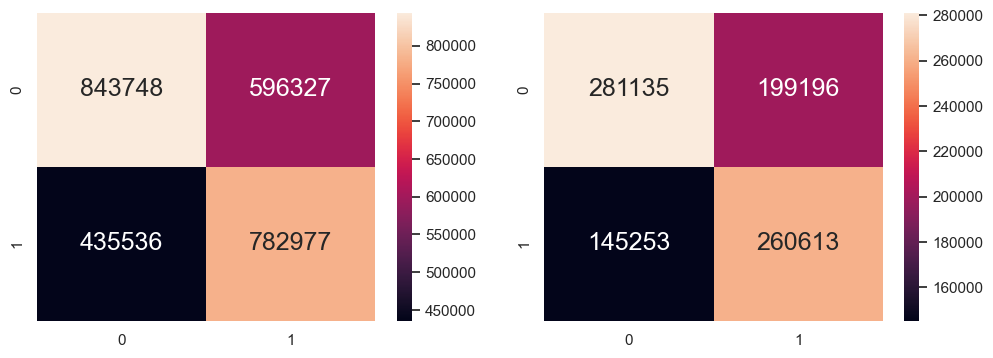

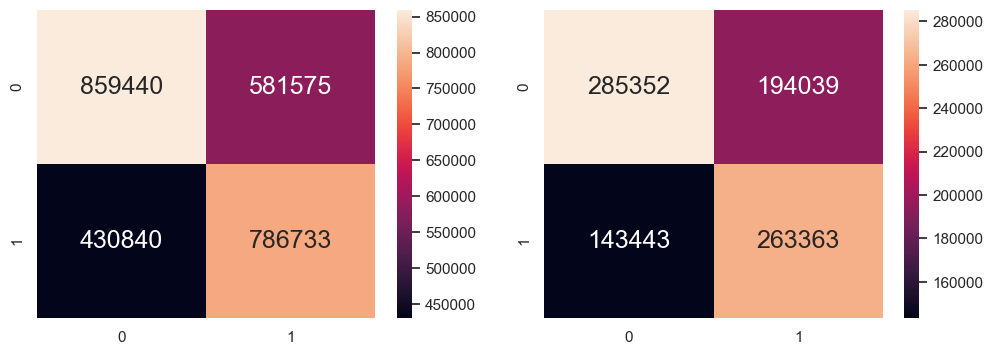

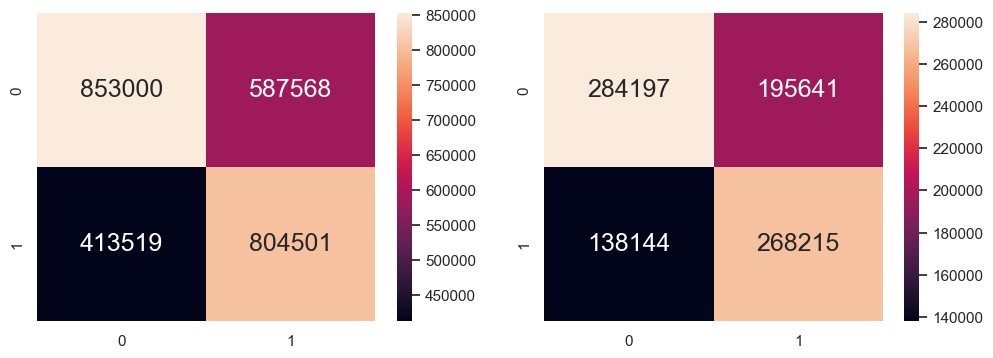

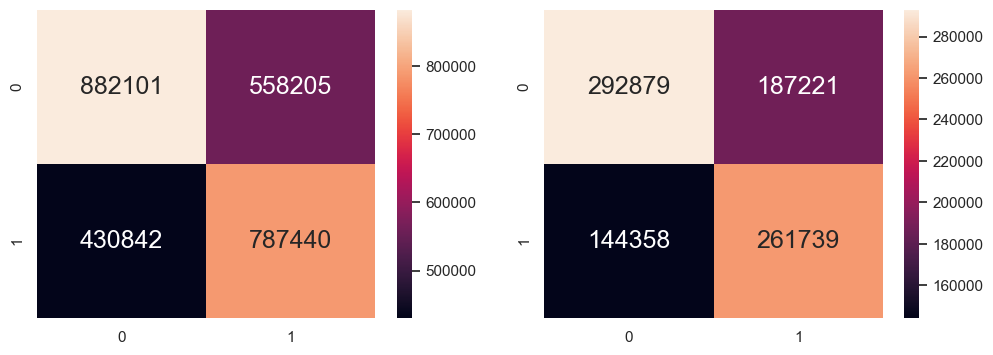

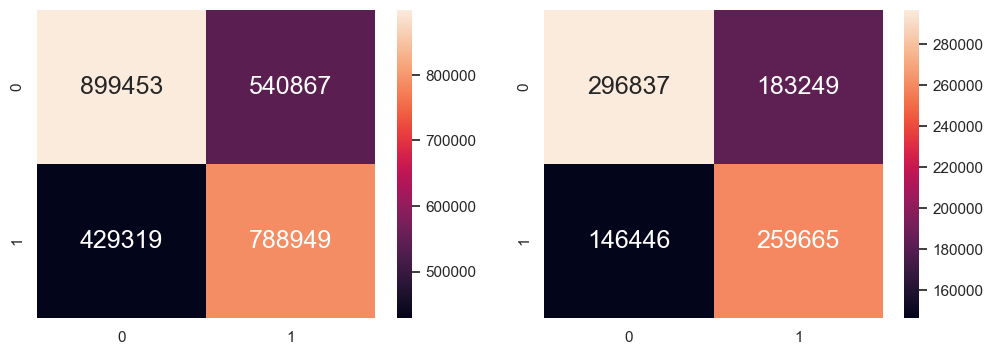

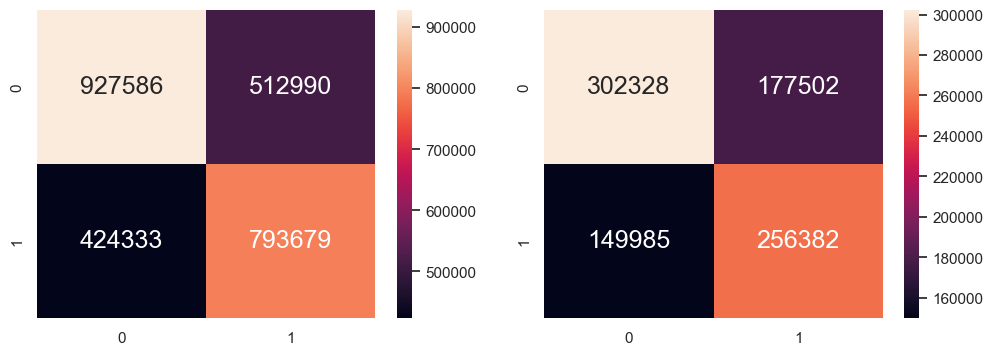

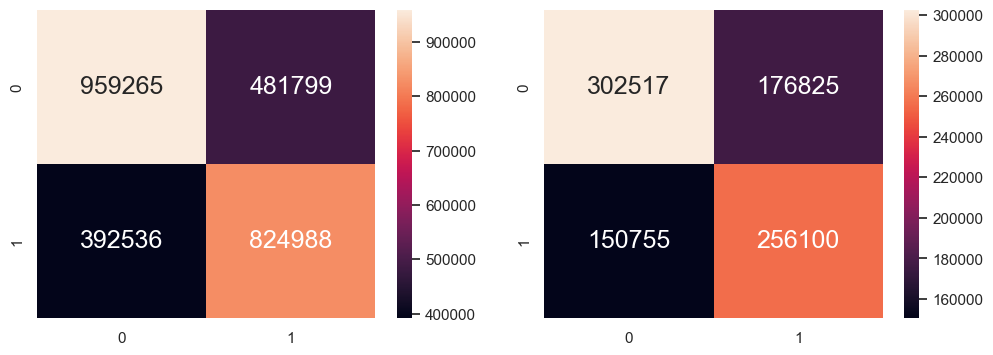

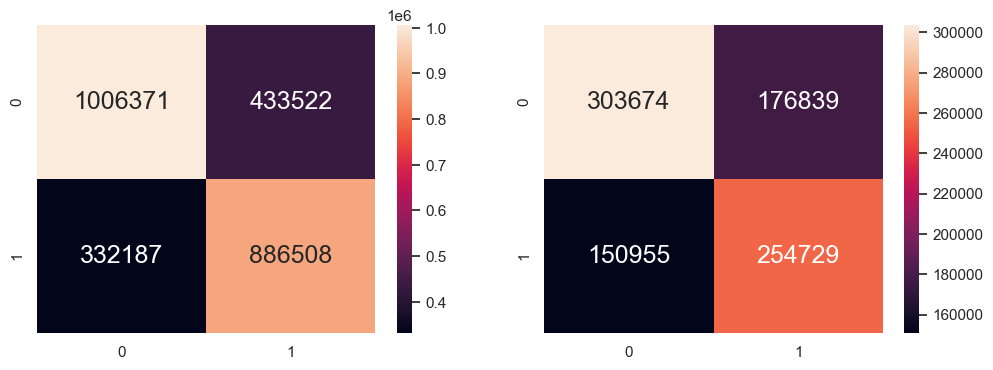

In [23]:
Accuracy = [] 
for depth in range (10):
    print(f"Random forest of 100 trees of depth {2*(depth+1)}")
    rf_classifier, acc = RandomForest(response, predictors,2*(depth+1))
    Accuracy.append(acc)

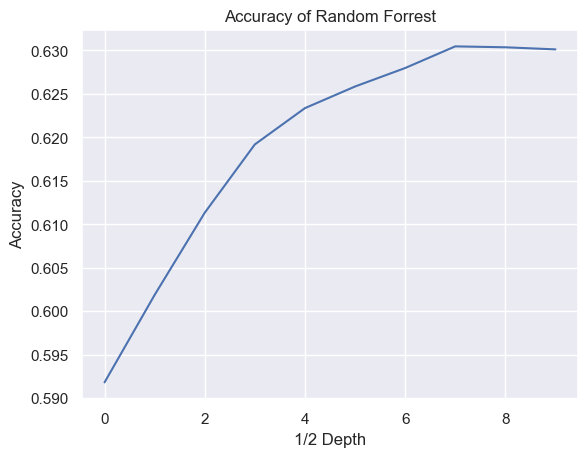

In [25]:
plt.plot(Accuracy)
plt.xlabel('1/2 Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forrest')
plt.show()

In [29]:
print(f'The highest accuracy achieved is {max(Accuracy)} is achieved at depth of {2*(np.argmax(Accuracy)+1)}')

The highest accuracy achieved is 0.6304580132859849 is achieved at depth of 16


As we can clearly see, the random forrest does not improve the accuracy of our model by a lot.\
A single classification tree with 6 features at depth 20 can provide a prediction accuracy of **62.46%**. Meanwhile, a random forests of 100 classification tree each with 2 features (~sqrt(6)) can also only provide a maximum prediction accuracy of **63.04%** at depth 16. This is only a **slight increase in accuracy.** \
\
This is because the variance of the sample and overfitting of train data is not the problem in our model. While random forest's key advantage over a simple classification tree is to reduce variance and over fitting, our large set of train data allows the variance of our sample representative enough of our data such that there is no problem of overfitting as observed, train accuracy and test accuracy only differs by **at most 0.2%**.

Hence, random forest model offers marginal improvement in accuracy while costing 100 times more computational resources, making it **an unsuitable model** for real time prediction of our data. 

We will now consider the other option of ensemble modelling: **Boosting**